# BrainStation Capstone Project: Predicting Covid News Sentiment with NLP
# Part 3: ML Modeling


**Date:      9/25/2022**  
**Author:  Eugene(Yen-Lin) Huang**  
**Part 3 of 3**  
**Conda Environment: base**

In this notebook, I will try to develop different models to predict sentiment of the COVID news articles. I will use the cleaned data in the previous note book. As I mentioned earlier, I will focus on trying different vectorization methods on the article text and see how we can best utilize the text information. In particular, four different vectorization methods are used:

- Bag-of-Words Count Vectorization
- TF-IDF Vectorization
- A Word2Vec embedding trained by my own neural network(Please refer to my previous notebook for more detail) 
- A more refined embedding implementation(LexVec) trained with full texts from English Wikipedia.  
  (This pre-trained embedding is provided to us by BrainStation. The source can be found [here](https://github.com/alexandres/lexvec))

For each transformation, I will try several different models with hyperparameter optimization. Finally, after selecting the best performing transformation, I will add other features to the model and run a quick grid search to finalize my modeling.

**Warning: Some of the cells in this notebook can run a few hours. Please refrain from running it if you want to read the output I have. Reminders will be given ahead of those cells**

Let's start by importing the necessary libraries and loading the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")
import joblib

The data I used here is the cleaned data from my data cleaning note book. The .csv file can be acquired [here](https://drive.google.com/file/d/1dlXsDPOqUvSK3qAc7RSkyg4psq6jyp9j/view?usp=sharing) 

In [2]:
covid_df = pd.read_csv('data/Covid_Dataset_Cleaned.csv').drop(columns='Unnamed: 0')
covid_df.head()

,id,Source,Date,Headline,Author,Main_Location,Language,Body,Sentiment_Body,Sentiment_Body_Score,Sentiment_Title,Sentiment_Title_Score
0,116204,Straits Times,2020-03-29,Coronavirus drives surge in Australia domestic...,unknown,SG,en,SYDNEY (AFP) - Australia on Sunday (March 29) ...,negative,-0.474486,neutral,0.0
1,824885,Business Standard,2020-05-02,Pilgrims from U'khand can visit Kedarnath from...,Press Trust,IN,en,Pilgrims from Uttarakhand can visit Kedarnath ...,negative,-0.600607,neutral,0.0
2,376185,Politico,2020-03-11,Exclusive: Email crash impeded HHS response to...,Dan Diamond,US,en,The previously unreported episode was the late...,negative,-0.678111,neutral,0.0
3,1639298,Reuters,2020-06-03,"Citadel hires portfolio managers for credit, s...",Svea Herbst-bayliss,NaN,en,"BOSTON, June 3 (Reuters) - Hedge fund Citadel,...",negative,-0.887686,neutral,0.0
4,96472,Reuters,2020-03-30,Airlines line up furloughs; Air New Zealand se...,Reuters Editorial,NaN,en,(Reuters) - Major global airlines projected la...,negative,-0.997323,neutral,0.0


Our target column is the article sentiment. It would be nice to take a look of its distribution.

<function matplotlib.pyplot.show(close=None, block=None)>

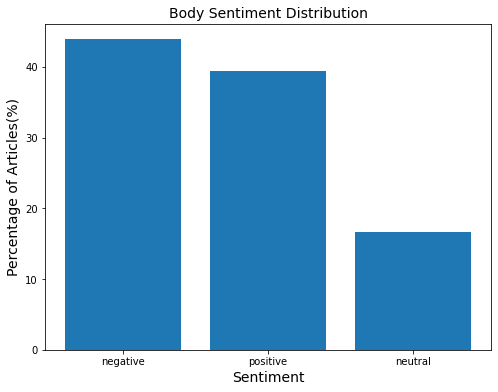

In [3]:
#caculate the fraction of articles in each category
sentiment_dist = covid_df['Sentiment_Body'].value_counts()/covid_df['Sentiment_Body'].shape[0]

#plotting the distribution of articles
plt.figure(figsize=(8,6))
plt.bar(covid_df['Sentiment_Body'].value_counts().index, sentiment_dist*100)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Percentage of Articles(%)', fontsize=14)
plt.title('Body Sentiment Distribution', fontsize=14)
plt.show

Our target variable is not exactly balanced but also not extremely imbalanced. There is no single category exceeds 50% of the articles. Also, there is no specific reasons indicating whether we should care more about false positive or false negative for each categories. Therefore, during my model optimization, I will use the overall accuracy as my evaluation metric, although I will report the confusion matrix for my final model.

I will first use only the body text of the article to see how good a result we can get just by using that. The first vectorization method I would like to try is the simple bag-of-words model, which vectorizes the article by counting how many times individual words appeared in the article.

## The Bag of Words Model 

In [3]:
X = covid_df['Body']
y = covid_df['Sentiment_Body'].map({'negative': 0,
                                    'neutral': 1,
                                    'positive': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

I will make sure the train/test split is stratified properly. 

In [5]:
for i in [0,1,2]:
    percent_train = len(y_train[y_train==i])/y_train.shape[0]
    percent_test = len(y_test[y_test==i])/y_test.shape[0]
    print(f'Percent of articles with sentiment={i} is {percent_train} in the training set, and {percent_test} in the testing set')

Percent of articles with sentiment=0 is 0.43904336406977074 in the training set, and 0.43904047063596713 in the testing set
Percent of articles with sentiment=1 is 0.16652273830254932 in the training set, and 0.16651935142654284 in the testing set
Percent of articles with sentiment=2 is 0.39443389762767994 in the training set, and 0.39444017793749003 in the testing set


I will now vectorize the text and fit a simple Logistic Regression to the model. The result would be the baseline performance we should expect when I proceed with my modeling.  

Vectorize my X_train and X_test:

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
# 1. Instantiate
bagofwords = CountVectorizer(stop_words='english', min_df=0.005) #restrict focus on the words appearing in at least 0.5% of the articles

# 2. Fit
bagofwords.fit(X_train)

# 3. Transform
X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

In [16]:
counts = np.array(X_train_transformed.sum(axis = 0))

word_counts = pd.DataFrame(
    {"counts": counts[0]},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

print(f'The transformed X_train now contain {len(bagofwords.get_feature_names_out())} features/words. \n')
print('The 20 words with top appearnce frequecies are:')

for i in range(0,50):
    print(f'\"{word_counts.index[i]}\"', end=' ')

The transformed X_train now contain 5485 features/words. 

The 20 words with top appearnce frequecies are:
"said" "coronavirus" "people" "covid" "19" "new" "year" "health" "time" "pandemic" "cases" "like" "government" "just" "home" "virus" "million" "state" "2020" "000" "day" "company" "going" "world" "work" "china" "week" "march" "business" "country" "public" "need" "market" "think" "number" "president" "news" "trump" "including" "help" "make" "told" "according" "10" "social" "don" "city" "ve" "outbreak" "lockdown" 

### 1. Logistic Regression

I will now develop a Logistic Regression model as my baseline. Since all features created by CountVectorizer is in the same unit (number of appearances), I do not need to scale the features here.

In [17]:
lm = LogisticRegression()
lm.fit(X_train_transformed, y_train)
score = lm.score(X_test_transformed, y_test)

print(f'The accuracy for my first Logistic Regression is: {score}')

The accuracy for my first Logistic Regression is: 0.646059438076884


The performance of my first model looks decent. However, there is potential to further improve it by fine-tuning the regularization hyperparameter. The regularization parameter specifies our choice regarding the bias-variance trade off. A strong regularization penalty prevent the model from over-fitting the trained data(higher bias), with the hope that the model would be more generalizable(lower variance), while weaker regularization let the model fit more closely to the training data(lower bias) but increase the risk of producing less generalizable results (higher variance).      

In the case of Logistic Regression, the strength of regularization is specified by C, which is negatively related to the regularization penalty. In order to fine-tune the regularization penalty C, I will create a validation set and re-train the model.

In [18]:
#recreate the training set(or the remainder set) from original data
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
#create validation set
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.20, stratify= y_remainder) 

#fit the count vactorizer to the training set, then transform the validation set
bagofwords = CountVectorizer(stop_words='english', min_df=0.005)
bagofwords.fit(X_train)
X_train_transformed = bagofwords.transform(X_train)
X_val_transformed = bagofwords.transform(X_val)

#instantiate emty list to store model scores
train_accur = list()
validation_accur = list()
Cs = [10**i for i in range(-4,5)] #different Cs I would like to try

#try different Cs and store the model performance
for c in Cs:
    #train and score the model 
    lm = LogisticRegression(C=c)
    lm.fit(X_train_transformed, y_train)
    train_score = lm.score(X_train_transformed, y_train)
    val_score = lm.score(X_val_transformed, y_val)
    
    train_accur.append(train_score)
    validation_accur.append(val_score)

I will now visualize the model performance in training/validation sets: 

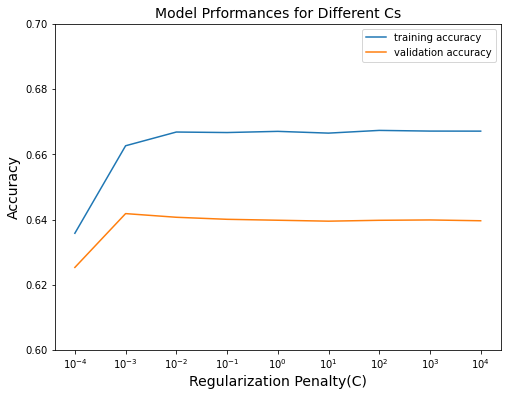

In [19]:
plt.figure(figsize=(8,6))

plt.plot(Cs, train_accur, label='training accuracy')          #Plotting training accruacy
plt.plot(Cs, validation_accur, label='validation accuracy')   #Plotting validation accruacy
plt.xscale('log') #Rescale the X-axis 
plt.xticks(Cs)
plt.xlabel('Regularization Penalty(C)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Prformances for Different Cs', fontsize=14)
plt.legend()
plt.ylim((0.6,0.7))

plt.show()

Model performances are similar across different Cs, but the validation score is slightly higher for C=0.001, which indicates a pretty strong regularization. Also, there does not seem to be a serious over-fitting problem as all accuracy scores are not too far apart between the training and validation sets. I will now use C=0.001 as my baseline model.

In [42]:
bagofwords = CountVectorizer(stop_words='english', min_df=0.005)
bagofwords.fit(X_remainder)
X_remainder_transformed = bagofwords.transform(X_remainder)
X_test_transformed = bagofwords.transform(X_test)

lm = LogisticRegression(C=0.001)
lm.fit(X_remainder_transformed, y_remainder)
score = lm.score(X_test_transformed, y_test)

print(f'The accuracy for my baseline Logistic Regression is: {round(score*100, 2)}%')

The accuracy for my baseline Logistic Regression is: 64.75%


The model performance is slightly better than my first model. I will create visualizations below to show the most predictive words for each categories. The cell below defines a function for the task.

In [42]:
def vis_logit_coef(coef, vector, sentiment):
    '''
    The function visualize the best predicting coefficients for the specified sentiment
    
    The "coef" imput should be the lm.coef_ matrix generated by the logit model.
    The "vector" imput is the name of the vectorization method used. This imput is used to extract coefficient names.
    
    '''
    sentlist = ['negative', 'neutral', 'positive']
    assert sentiment in sentlist, 'Unrecognized Sentiment Category'
    
    sent2int = dict()
    for i, j in enumerate(['negative', 'neutral', 'positive']):
        sent2int[j] = i
    
    df = pd.DataFrame(data ={'factor': np.exp(coef[sent2int[sentiment]])},
                          index = vector.get_feature_names_out()).sort_values(by='factor', ascending=False).head(10)
    
    plt.figure(figsize=(8,6))

    sorted_df = df.sort_values(by='factor')
    plt.barh(sorted_df.index, sorted_df['factor'])
    plt.title(f'Top words associated with {sentiment} sentiment', fontsize=14)
    plt.xlabel('Probability Factor from Logistic Regression', fontsize=14)

    plt.show()

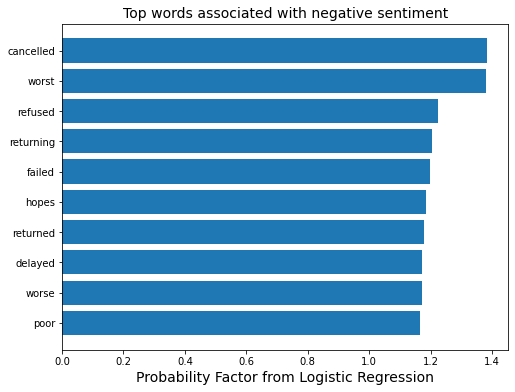

In [28]:
vis_logit_coef(lm.coef_, bagofwords, 'negative')

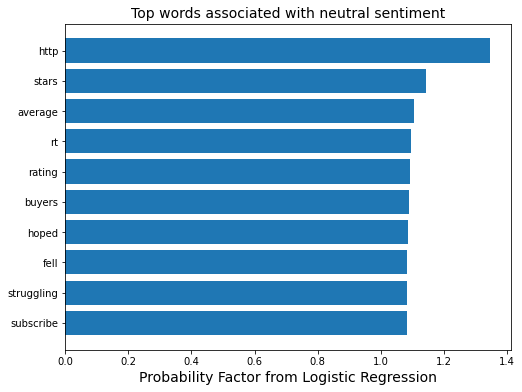

In [29]:
vis_logit_coef(lm.coef_, bagofwords, 'neutral')

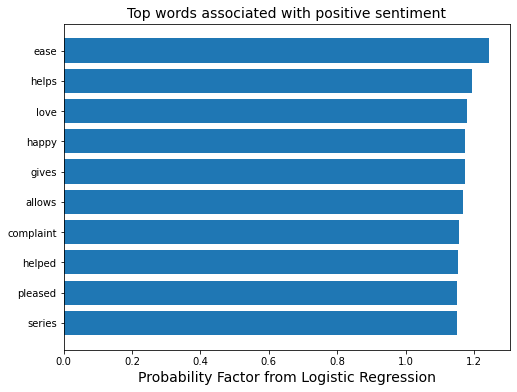

In [30]:
vis_logit_coef(lm.coef_, bagofwords, 'positive')

The above graphs shows the words that are most strongly associated with each sentiment categories. For example, if the word `cancelled` has one more appearance in the article, the chance that the article has a negative sentiment will increase by 1.4 times. 

The top 5 words that predict a positive sentiment are: `ease`, `helps`, `love`, `happy`, `gives`  
The top 5 words that predict a neutral sentiment are: `http`, `stars`, `average`, `rt`, `rating`  
The top 5 words that predict a negative sentiment are: `cancelled`, `worst`, `refused`, `returning`, `failed` 

### 2. KNN Model

I will now try to fit the KNN model to the vectorized article texts and see how it performs comparing with the Logistic Regression. KNN models predict the category of an observation by looking at the "closest" data points around it, therefore, how to measure the distance between data points is important to its performance. I first try to fit the model using cosine similarity. Comparing with Euclidean distance, cosine similarity can better capture the "trend" of whether certain words appears together in the article. I would expect this kinds of distance measure can better capture the similarity between article context.

Since KNN is computationally expensive, I will first apply Latent Semantic Analysis(LSA) to reduce the number of dimensions of my data. LSA is a dimension-reduction technique similar to PCA but is more applicable under the context of NLP and word count vectors. More importantly, PCA method in Sklearn does not work with sparse matrices, while the Truncated SVD algorithm for LSA does. I will follow the steps below to fine-tune the hyperparameter:

- train/validation split
- vectorize the body text
- apply LSA
- Calculate the distances between data points(for both training and validation sets)
- try different Ks and report the scores

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.20, stratify= y_remainder) 

#Vectorize the body text
bagofwords = CountVectorizer(stop_words='english', min_df=0.005)
bagofwords.fit(X_train)
X_train_transformed = bagofwords.transform(X_train)
X_val_transformed = bagofwords.transform(X_val)

Now that I have split the data, I will decide on the number of dimensions I want to keep so that my data can still retain at least 90% of the variance. I will try to keep 2000 features at first and visualize the cumulated explained variance below. 

In [7]:
from sklearn.decomposition import TruncatedSVD

**Note: It takes about 20 minutes for me to run the cell below** 

In [10]:
LSA = TruncatedSVD(n_components=2000) #Instantiate LSA with 2000 fetures
LSA.fit(X_train_transformed)
#transform the data with the fitted LSA
X_train_LSA = LSA.transform(X_train_transformed)
X_val_LSA = LSA.transform(X_val_transformed)

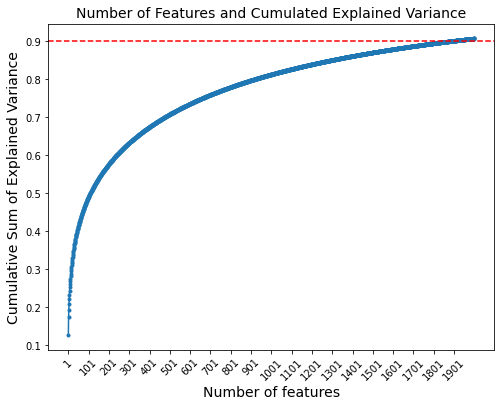

The minimum number of feature that captures at least 90% of the variance is 1874


In [11]:
# Plot out the cumulative explained variance
cumulative_sum = np.cumsum(LSA.explained_variance_ratio_)

plt.figure(figsize=(8,6))
plt.plot(range(1,2001), cumulative_sum, marker='.')
plt.axhline(0.9, c='r', linestyle='--')
plt.xlabel('Number of features', fontsize=14)
plt.ylabel('Cumulative Sum of Explained Variance', fontsize=14)
plt.xticks(range(1,2001,100), rotation = 45)
plt.title('Number of Features and Cumulated Explained Variance', fontsize=14)
plt.show()

print(f'The minimum number of feature that captures at least 90% of the variance is {np.where(cumulative_sum>=0.9)[0][0]}')

As the above graph shows, keeping 1,874 features will allow me to retain 90% of the variance in my dataset. I will reduce the dimension of X to 1,874 features.

In [12]:
#Apply the LSA with 1,847 features to my data
LSA = TruncatedSVD(n_components=1874)
LSA.fit(X_train_transformed)
X_train_LSA = LSA.transform(X_train_transformed)
X_val_LSA = LSA.transform(X_val_transformed)

Since KNN is computationally heavy, it is more efficient to calculate the the distance between all data points. Once the distances are calculated, it can be used to fit models with different Ks relatively fast. The cell below calculates and stores the distances(cosine similarity between different data points). Note that this needs to be done for both training and validation sets.

**Note: The following cell runs for more than an hour on my laptop**

In [13]:
#Calculate all the distances between data points and stores the top 40 closest distance
K_transform = KNeighborsTransformer(n_neighbors=40, metric='cosine')
K_transform.fit(X_train_LSA)
#storing the pre-caluclated distances in matrices
X_Distance_train = K_transform.transform(X_train_LSA)
X_Distance_val = K_transform.transform(X_val_LSA)

Now that the distances between data points are stored, they can be used to fit KNN models with different Ks.

In [14]:
train_accur = list()
validation_accur = list()
Ks = range(1,41)

for k in Ks:  
    my_KNN = KNeighborsClassifier(n_neighbors=k, metric='precomputed') # 'precomputed' metric allows us to use the calculated distances 
    my_KNN.fit(X_Distance_train, y_train)
    #calculate the training and validation scores 
    training_acc = my_KNN.score(X_Distance_train, y_train)
    validation_acc = my_KNN.score(X_Distance_val, y_val)
    
    #append the training and validation scores 
    train_accur.append(training_acc)
    validation_accur.append(validation_acc)

Models with K from 1 to 40 are fitted. The performances are visualized below:

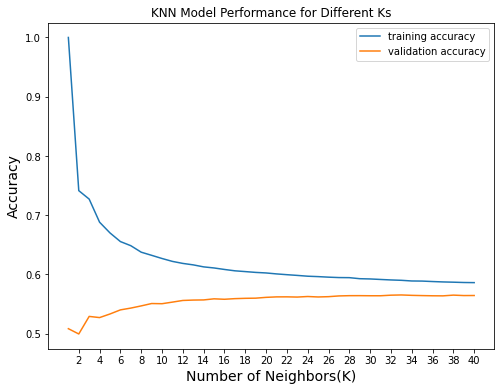

In [15]:
#plot the performances
plt.figure(figsize=(8,6))

plt.plot(Ks, train_accur, label='training accuracy')
plt.plot(Ks, validation_accur, label='validation accuracy')
plt.xticks(Ks)
plt.xlabel('Number of Neighbors(K)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks([i for i in 2*np.arange(1,21)])
plt.title('KNN Model Performance for Different Ks')
plt.legend()

plt.show()

From K=10 to K=40, the validation accuracy only slightly increased, although there seems to be less overfitting issues with larger Ks. To balance the model performance and my computational power, I will choose K=20 and refit the model on my full training set. I will use the vectorized X_remainder_transformed created earlier when I ran my Logistic Regression, fitted the LSA, and then fit the KNN model with K=20:

In [20]:
#Re-apply the LSA for the full remainder data, which is now my training set
LSA = TruncatedSVD(n_components=1874)
LSA.fit(X_remainder_transformed )
X_remainder_LSA = LSA.transform(X_remainder_transformed )
X_test_LSA = LSA.transform(X_test_transformed)

#Fit and score the KNN model
my_KNN = KNeighborsClassifier(n_neighbors=20, metric='cosine')
my_KNN.fit(X_remainder_LSA, y_remainder)
test_acc = my_KNN.score(X_test_LSA, y_test)

In [21]:
print(f'The accuracy score for my KNN model is {round(test_acc*100, 2)}%')

The accuracy score for my KNN model is 56.25%


Even though the KNN model is significantly more expensive computationally, it does not perform better than the Logistic Regression. I will now try a decision tree model and see how it performs.

### 3. Decision Tree Model

I will now try to fit a decision tree model. Similar to the above, I will first use the train/validation sets to optimize the hyper parameter. Moreover, I will use cross-validation for a more robust hyper parameter selection process.

In a cross-validation process, multiple train/validation splits are created for the same hyperparameter. The model performance scores are averaged across different split as an evaluation of the model for a specific hyperparameter. Finally, the best hyperharameter is chosen after inspecting the train/validation performances. 

In order to avoid potential information leakage, it is best practice to refit the CountVectorizer for every training set from different splits rather than fitting on the whole "remainder" set and do multiple train-test splits afterwards. I will write a pipeline and utilize grid search to facilitate this process. 

In [12]:
#Define my pipeline for each train/validation split:

#For each train/validation split, I will fit CountVectorizer() on the traning set, transform the traning set and fit the model, 
#then transform the validation set and evaluate the scores.
estimators = [('Vectorizer', CountVectorizer(stop_words='english', min_df=0.005)),
              ('model', DecisionTreeClassifier())]
    
my_pipe = Pipeline(estimators)

Now that I've specified the procedures in my pipeline, I will instantiate the grid search.

The GridSearchCV object allow us to specify multiple hyperparameters and search for the best. For each parameter, it create 5 different train/validation splits and calculate the average performance. For the decision tree, the hyperparameter to be optimized is max_depth. This is again a bias-variance trade off. With a large depth, decision trees tend to over-fit and produce less generalizable result, but when the depth is too small, we are not utilizing enough information in the training set. 

In [38]:
#Define the parameters to be searched during the cross-validation  
params = {'model__max_depth': [i*2 for i in range(1,11)]}
skf = StratifiedKFold(n_splits=5) #used in the grid to create stratified splits

my_grid = GridSearchCV(my_pipe, param_grid=params, cv=skf, return_train_score=True, n_jobs=-1) #Instantiate the grid

fittedgrid_tree = my_grid.fit(X_remainder, y_remainder) #fit the grid

In [60]:
print(f"The best performing max_depth for the validation set is: {fittedgrid_tree.best_params_['model__max_depth']}")

The best performing max_depth for the validation set is: 14


The Decision Tree with max_depth=14 has the best testing set performance.

In [67]:
trainscore14 = 100*fittedgrid_tree.cv_results_['mean_train_score'][6] #average training score for max_depth=14
valscore14 = 100*fittedgrid_tree.cv_results_['mean_test_score'][6] #average validation score for max_depth=14

print(f"Average Training score for this specification is: {trainscore14.round(2)}%")
print(f"Average Testing score for this specification is: {valscore14.round(2)}%")
print(f"The difference is {(trainscore14-valscore14).round(2)}%")

Average Training score for this specification is: 58.98%
Average Testing score for this specification is: 54.17%
The difference is 4.81%


Different scores for different tree depths are visualized below: 

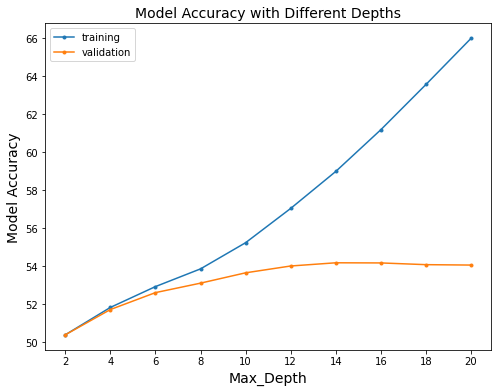

In [71]:
#extract the average train and validation scores from the fitted search result
mean_train = fittedgrid_tree.cv_results_['mean_train_score']
mean_val = fittedgrid_tree.cv_results_['mean_test_score']

plt.figure(figsize=(8,6))
plt.plot([i*2 for i in range(1,11)], mean_train*100, marker='.', label='training')
plt.plot([i*2 for i in range(1,11)], mean_val*100, marker='.', label='validation')
plt.xticks([i*2 for i in range(1,11)])
plt.xlabel('Max_Depth', fontsize=14)
plt.ylabel('Model Accuracy', fontsize=14)
plt.title('Model Accuracy with Different Depths', fontsize=14)
plt.legend()
plt.show()


The performance of the validation set is optimized at max_depth = 14, and there doesn't seem to be serious overfitting issues as the training set performance is only 4.81% higher than the validation set. The examination below will proceed with this hyperparameter and see how it performs on the testing set.

In [10]:
#Vectorize the body text
bagofwords = CountVectorizer(stop_words='english', min_df=0.005)
bagofwords.fit(X_remainder)
X_rem_transformed = bagofwords.transform(X_remainder)
X_test_transformed = bagofwords.transform(X_test)

In [11]:
#fit the decision tree model with the chosen hyperparameter
my_tree = DecisionTreeClassifier(max_depth=14)
my_tree.fit(X_rem_transformed, y_remainder)
test_acc_tree = my_tree.score(X_test_transformed, y_test)

print(f'The test accuracy for my best Decision Tree model is: {round(test_acc_tree*100, 2)}%')

The test accuracy for my best Decision Tree model is: 54.51%


The performance of Decision Tree Model is worse than both KNN and Logistic Regression.

I have now tried three different models to predict the article sentiment using the CountVectorizer. The best performing model is **Logistic Regression, which has a 64.75% testing accuracy**. I will now try different vectorization or embedding methods to see if they improve my model.  

## TF-IDF Vectorization

In the previous modeling, the most basic CountVectorizer was used to vectorize the articles. I will now try to use the `TF-IDF` Vectorization and see how the models perform. `TF-IDF` is essentially a weighted version of CountVectorizer. Instead of weighting each term equally, TF-IDF adjust the importance of a word based on it's appearance frequency. The `TF` part overweights a term if it appears more frequently in a given article. Intuitively, if a word appears more frequently in an article, it probably carries more weight on what the article is about. On the other hand, the `IDF` part underweights a word if it appears more frequently across different articles in the whole corpus. The idea is that, if a word appears in every articles, chances are that it is not that important when it comes to the different opinions/sentiment of the individual article. For example, the word `Covid` probably appears in many of the news articles about Covid19, but would not help gauge the different sentiment for individual articles.  

For TF-IDF vectorization, I will first try to use pipeline and grid search to perform cross-validation and figure out the best model among Decision Trees and Logistic Regression. And then examine the performance of KNN in separately with a single train/validation split. The reason that I do not perform cross-validation on KNN is that KNN is extremely computational expensive when scoring a model. For a single train/validation split, I can save the calculated distance then score the model for different Ks. However, under cross-validation, the distance need to be recalculated for each different splits, and the required time would be exponentially increased. For the time and resource constraint I have, I will proceed with what I described here.

Below I will start the cross-validation/grid search for the Logistic Regression and Decision Trees:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

Defining the pipeline for each train-validation split as before:

In [8]:
#Define my pipeline for each train/validation split:

#Note that the model name(DecsionTree) here is just a place holder, as I will specify other models to be searched in the grid search.
estimators = [('Vectorizer', TfidfVectorizer(stop_words='english', min_df=0.005)),
              ('model', DecisionTreeClassifier())]
    
my_pipe = Pipeline(estimators)

This time, I will extend the parameters to search on different models:

In [9]:
params = [
    {
     'model': [DecisionTreeClassifier()],
     'model__max_depth': [i*2 for i in range(1,11)]
    },
    {
     'model': [LogisticRegression()], 
     'model__C': [10**i for i in range(-4,5)]
    }]

skf = StratifiedKFold(n_splits=5) #used in the grid to create stratified splits
my_grid = GridSearchCV(my_pipe, param_grid=params, cv=skf, return_train_score=True, n_jobs=-1) #Instantiate the grid

**Note: The following cell runs for a pretty long time on my laptop**

In [ ]:
fittedgrid_tree = my_grid.fit(X_remainder, y_remainder) #fit the grid

In [13]:
print(f"The best performing model among the searched is: {fittedgrid_tree.best_params_['model']}")

The best performing model among the searched is: LogisticRegression(C=1)


Among all specification across Logistic Regression and Decision Tree, the best performing model is the Logistic Regression with C=1. 

In [20]:
trainscore_c1 = 100*fittedgrid_tree.cv_results_['mean_train_score'][-5]
testscore_c1 = 100*fittedgrid_tree.cv_results_['mean_test_score'][-5]

print(f"Average Training score for this specification is: {trainscore_c1.round(2)}%")
print(f"Average Validation score for this specification is: {testscore_c1.round(2)}%")
print(f"The difference is {(trainscore_c1-testscore_c1).round(2)}%")

Average Training score for this specification is: 67.62%
Average Validation score for this specification is: 65.86%
The difference is 1.75%


The best model among the search is Logistic Regression with C=1, which has a 65.86% validation accuracy on average. The score of the training set suggests there is no serious overfitting issues. I will proceed and check the performance of this model on the testing set.

In [ ]:
#Transform the remainder set
tfidf = TfidfVectorizer(stop_words='english', min_df=0.005)
tfidf.fit(X_remainder)
X_rem_transformed_tf = tfidf.transform(X_remainder)
X_test_transformed_tf = tfidf.transform(X_test)

In [33]:
lm = LogisticRegression(C=1)
lm.fit(X_rem_transformed_tf, y_remainder)
score = lm.score(X_test_transformed_tf, y_test)

print(f'The accuracy for my baseline Logistic Regression is: {round(score*100, 2)}%')

The accuracy for my baseline Logistic Regression is: 65.96%


Similarly, I can visualize the best predicting words of the sentiment:

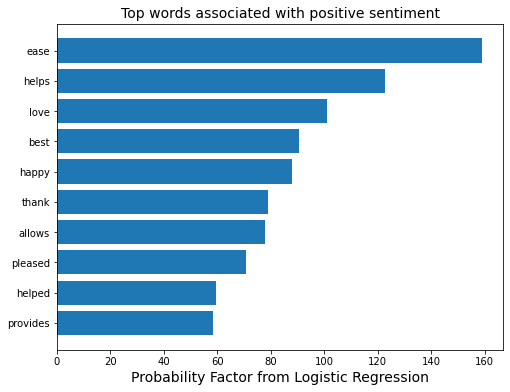

In [35]:
vis_logit_coef(lm.coef_, tfidf, 'positive')

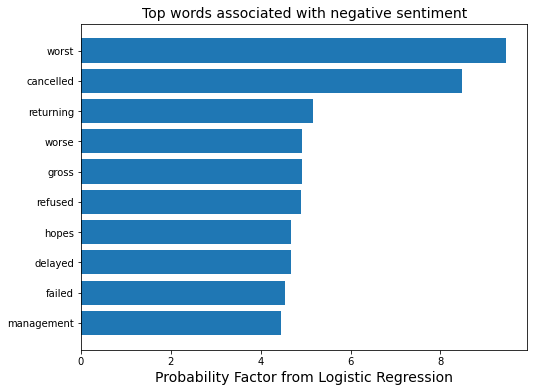

In [21]:
vis_logit_coef(lm.coef_, tfidf, 'negative')

The factors represent how much impact a word has on the sentiment prediction. With TF-IDF vectorization, it is not very clear what it means if the word feature increases by unit, but we can consider these words as the ones having more impact on the article sentiment in general. The list of words is pretty similar to what we had for the Bag-of-Words model.  

Now, I will also check the KNN model performance for TF-IDF vectorization. Similar to what is done in the bag of word model, I will calculate all the distances between all observations, then score the model with different Ks and optimize the choice.

Also similar to what I have done above, LSA is applied to reduce the dimension. I will keep 1,874 components as before and examine the explained variance. 

In [7]:
#Single train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_remainder, y_remainder, test_size=0.20, stratify= y_remainder) 

#Vectorize the body text with TF-IDF
tfidf = TfidfVectorizer(stop_words='english', min_df=0.005)
tfidf.fit(X_train)
X_train_transformed_tf = tfidf.transform(X_train)
X_val_transformed_tf = tfidf.transform(X_val)

In [10]:
#Reduce the dimension with LSA
LSA = TruncatedSVD(n_components=1874)
LSA.fit(X_train_transformed_tf)
X_train_LSA_tf = LSA.transform(X_train_transformed_tf)
X_val_LSA_tf = LSA.transform(X_val_transformed_tf)

The cell below shows the cumulated explained variance ratio for 1,874 components.

In [11]:
cumulative_sum = np.cumsum(LSA.explained_variance_ratio_)
print(f'{(cumulative_sum[-1]*100).round(2)}% of the variance is explained with 1,874 components')

72.48% of the variance is explained with 1,874 components


I will proceed with this and check the KNN performance. The distances are first calculated below: 

In [12]:
K_transform = KNeighborsTransformer(n_neighbors=40, metric='cosine')
K_transform.fit(X_train_LSA_tf)
X_Distance_train = K_transform.transform(X_train_LSA_tf)
X_Distance_val = K_transform.transform(X_val_LSA_tf)

With the distances calculated, models with different Ks can be quickly scored:

In [13]:
train_accur = list()
validation_accur = list()
Ks = range(1,41)

for k in Ks:  
    my_KNN = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
    my_KNN.fit(X_Distance_train, y_train)
    training_acc = my_KNN.score(X_Distance_train, y_train)
    validation_acc = my_KNN.score(X_Distance_val, y_val)
    
    train_accur.append(training_acc)
    validation_accur.append(validation_acc)

Models with K from 1 to 40 are fitted. The performances are visualized below:

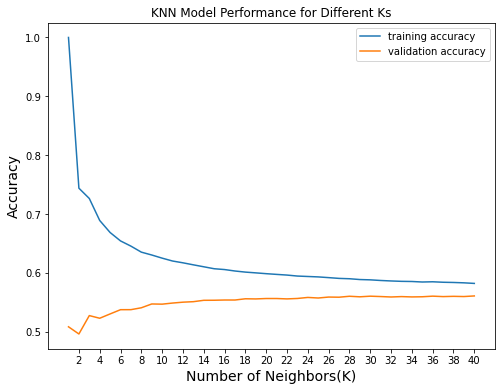

In [14]:
plt.figure(figsize=(8,6))

plt.plot(Ks, train_accur, label='training accuracy')
plt.plot(Ks, validation_accur, label='validation accuracy')
plt.xticks(Ks)
plt.xlabel('Number of Neighbors(K)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks([i for i in 2*np.arange(1,21)])
plt.title('KNN Model Performance for Different Ks')
plt.legend()

plt.show()

The performance of the validation set barely improves after K=10. I will choose K=18 as my model.

The model is fit to the whole remainder dataset below and the testing score is checked:

In [8]:
#Reduce the dimension with LSA
LSA = TruncatedSVD(n_components=1874)
LSA.fit(X_rem_transformed_tf)
X_rem_LSA_tf = LSA.transform(X_rem_transformed_tf)
X_test_LSA_tf = LSA.transform(X_test_transformed_tf)

#Fit the KNN model and score the model
my_KNN = KNeighborsClassifier(n_neighbors=18, metric='cosine')
my_KNN.fit(X_rem_LSA_tf, y_remainder)
test_acc = my_KNN.score(X_test_LSA_tf, y_test)

In [9]:
print(f'The accuracy score for my KNN model is {round(test_acc*100, 2)}%')

The accuracy score for my KNN model is 55.62%


Since KNN is computationally way more expensive than the other models, and does not seem to perform so far, for the remainder of this notebook, I will focus on the other models.

To provide a brief summary, **the best performing model under TF-IDF transformation is again the Logistic Regression. The testing accuracy is 65.96%**, which is slightly better than that of the Bag-of-Words model. 

Next, I will use the Word2Vec embedding trained by my own neural network to vectorize my body texts. 

## My Own Word2Vec Embedding

In this section, I will apply a Word2Vec embedding trained by my own neural network to the text.

The idea of word embedding is to represent each word with a vector, with each dimension of the vector representing certain aspect of the word. Word2Vec is a particular word embedding method trained under a particular neural network architecture. I have followed the architecture and trained my own embedding(with each word represented by an 100-dimension vector) using neural network. The detail of the training process is documented in the previous notebook of this project.

To take a look of the embedding, I will load the embedding model by calling the saved dictionary:

In [5]:
my_own_w2v = joblib.load('data/my_own_w2v.pkl') #Calling the saved embedding 

I can pass in any word as the key(provided that the word is presented in my training document), and the model will return the vector representing that word.

For example, the vector representing the word "australia" looks something like this:

In [8]:
my_own_w2v['australia'] 

array([ 0.54024744, -0.04149971, -0.20220499, -0.28711826,  0.03638756,
        0.788589  ,  0.02969736, -0.11178477, -0.5725266 , -0.17819262,
        0.23404142, -0.02535134,  0.1814522 ,  0.11111259, -0.1075007 ,
       -0.484567  ,  0.2444715 ,  0.17013709,  0.3940942 , -0.51014316,
       -0.03377568, -0.38296995,  0.18155386, -0.8299086 , -1.0911549 ,
       -0.6864811 , -0.17364815, -0.0929661 ,  0.5284349 , -0.41676232,
        0.33802626,  0.00283943,  0.53435796, -0.29828548,  0.19432774,
       -0.44966623,  0.14516331,  0.74801016, -0.02360087, -0.3782345 ,
        0.87468517,  0.59711903, -0.43472236,  0.32793707,  0.7746121 ,
       -0.18719037,  0.37805504, -0.8575068 , -0.8623102 ,  0.510714  ,
        0.00812747,  0.25704175,  0.38123965, -0.5025245 ,  0.19357468,
        0.1479367 , -0.10365386, -0.37709504,  0.43712136,  0.30075842,
        0.4412203 ,  0.10187035, -0.48409182,  0.53303784, -0.5633318 ,
       -0.43589616, -0.611897  , -0.8313048 , -0.7152454 , -0.16

To see how many words are in my embedding model:  

In [14]:
print(f"The model contains {len(my_own_w2v)} words, each represented by a {my_own_w2v['australia'].shape[0]}-dimension vector")

The model contains 50711 words, each represented by a 100-dimension vector


Now, to apply the word embedding to the whole article, I simply calculated the average of the vectors for all words presented in a single article. If a word in the article is not in my embedding model, the vector of the word would be zero.

The following function takes an article as the input and returns the embedded vector of that article.  
**Note: This function is modified using one of the functions provided in BrainStation notebooks.**

In [4]:
import gensim
from gensim.utils import simple_preprocess

def sentence2vec(text, model, dim):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    
    "model" specifies the trained word2vec model, which needs to be a dictionary-like object with the word string being the key and
    the word vector being the corresponding value
    
    "dim" specifies number of dimesions of the word vector
    -----
    
    Input: text (string), w2v model name, the number of dimesions of the word vector
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    
    
    word_embeddings = [np.zeros(dim)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(dim)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

I will now apply the embedding on the texts to see how the models perform.

Note that the embedding is trained independent to the training or validation data, so I can just fit it to the whole remainder dataset before the train/validation split without information leakage issues (i.e. the transformation is based on predetermined words in my word2vec model instead of the information in the training data).

The following cell transforms my text data:

In [7]:
#applying the sentence2vec function to each row(article)
X_rem_emb = np.array(X_remainder.apply(lambda x: sentence2vec(x, my_own_w2v, 100)).to_list())
X_test_emb = np.array(X_test.apply(lambda x: sentence2vec(x, my_own_w2v, 100)).to_list())

Again, I will use grid search to search for the best performing model under this embedding transformation.

In [26]:
#instantiate the pipeline
estimators = [('model', DecisionTreeClassifier())]
my_pipe = Pipeline(estimators)

#specifies the models/hyperparameters to be searched 
params = [
    {
     'model': [DecisionTreeClassifier()],
     'model__max_depth': [i*2 for i in range(1,11)]
    },
    {
     'model': [LogisticRegression()], 
     'model__C': [10**i for i in range(-4,5)]
    }]

skf = StratifiedKFold(n_splits=5) #used in the grid to create stratified splits
my_grid = GridSearchCV(my_pipe, param_grid=params, cv=skf, return_train_score=True)

**Note: The following cell runs for a few hours on my laptop**

In [27]:
gridsearch_w2v = my_grid.fit(X_rem_emb, y_remainder) #fit the grid

Since the search took a long time, I have saved the result.

In [28]:
joblib.dump(gridsearch_w2v, 'data/gridsearch_myown_w2v.pkl') #saving the grid search result

['data/gridsearch_myown_w2v.pkl']

One could simply load the saved result by running the following cell:

In [13]:
gridsearch_w2v = joblib.load('data/gridsearch_myown_w2v.pkl')

The grid search returns the following best-performing model:

In [29]:
gridsearch_w2v.best_params_['model']

LogisticRegression(C=10000)

The best performing model is the Logistic Regression with C=10,000, which indicates pretty weak regularization.  
The train/validation performances are as follows:

In [30]:
trainscore_c10000 = 100*gridsearch_w2v.cv_results_['mean_train_score'][-1]
testscore_c10000 = 100*gridsearch_w2v.cv_results_['mean_test_score'][-1]

print(f"Average Training score for this specification is: {trainscore_c10000.round(2)}%")
print(f"Average Validation score for this specification is: {testscore_c10000.round(2)}%")
print(f"The difference is {(trainscore_c10000-testscore_c10000).round(2)}%")

Average Training score for this specification is: 56.44%
Average Validation score for this specification is: 56.43%
The difference is 0.01%


The model performs almost identically in both training and validation datasets, suggesting no over-fitting issues.

Now I can test the model performance using the full remainder and testing sets: 

In [8]:
lm = LogisticRegression(C=10000)
lm.fit(X_rem_emb, y_remainder)
score = lm.score(X_test_emb, y_test)

print(f'The accuracy for the best model with Word2Vec embedding is: {round(score*100, 2)}%')

The accuracy for the best model with Word2Vec embedding is: 56.56%


The Word2Vec embedding does not perform as well as the TF-IDF and the Bag-of-Words models. I will move on an explore the performance of a more advanced pre-trained embedding.

## The Pre-Trained LexVec Embedding

Now that we have tried my own version of Word2Vec embedding, let's look at how such an embedding can perform if trained on all text on Wikipedia and with a more fine-tuned training architecture! For this task, I will import a well-trained LexVec embedding and interact with it using the `gensim` library.

As mentioned earlier, this is a pre-trained embedding. [This](https://github.com/alexandres/lexvec) is the original source, and the file can be downloaded [here](https://drive.google.com/file/d/1TsL8TsJMearbW7telCmp7l6HqSnunAhn/view?usp=sharing)

I will import the LexVec model:

In [9]:
#Loading the embedding model with gensim
w2v = gensim.models.KeyedVectors.load_word2vec_format(
    'data/lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False)

To take a closer look:

In [6]:
print(f'The model contains {w2v.vectors.shape[0]} words, each represented by a {w2v.vectors.shape[1]}-dimension vector')

The model contains 368999 words, each represented by a 300-dimension vector


I will now apply the embedding function to the texts and examine the performances of different models. 

Again. the embedding is independent to the training or validation data, so I can fit it to the whole remainder dataset before the train/validation split without worrying about information leakage.

In [10]:
#applying the embedding to my text data
X_rem_emb = np.array(X_remainder.apply(lambda x: sentence2vec(x, w2v, 300)).to_list())
X_test_emb = np.array(X_test.apply(lambda x: sentence2vec(x, w2v, 300)).to_list())

Grid search the best model:

In [11]:
estimators = [('model', DecisionTreeClassifier())]
my_pipe = Pipeline(estimators)

params = [
    {
     'model': [DecisionTreeClassifier()],
     'model__max_depth': [i*2 for i in range(1,11)]
    },
    {
     'model': [LogisticRegression()], 
     'model__C': [10**i for i in range(-4,5)]
    }]

skf = StratifiedKFold(n_splits=5) #used in the grid to create stratified splits
my_grid = GridSearchCV(my_pipe, param_grid=params, cv=skf, return_train_score=True) #Instantiate the grid

**Note: The following cell runs for a few hours on my laptop**

In [13]:
gridsearch_w2v = my_grid.fit(X_rem_emb, y_remainder) #fit the grid

Since the search took a long time, I have saved the result.

In [16]:
joblib.dump(gridsearch_w2v, 'data/gridsearch_w2v.pkl')

['data/gridsearch_w2v.pkl']

One could simply load the saved result by running the following cell:

In [12]:
gridsearch_w2v = joblib.load('data/gridsearch_w2v.pkl')

The grid search returns the following best-performing model:

In [18]:
gridsearch_w2v.best_params_['model']

LogisticRegression(C=10)

The best performing model under the LexVec embedding method is the Logistic Regression with C=10  
The train/validation performances are as follows:

In [25]:
trainscore_c10 = 100*gridsearch_w2v.cv_results_['mean_train_score'][-4]
testscore_c10 = 100*gridsearch_w2v.cv_results_['mean_test_score'][-4]

print(f"Average Training score for this specification is: {trainscore_c10.round(2)}%")
print(f"Average Validation score for this specification is: {testscore_c10.round(2)}%")
print(f"The difference is {(trainscore_c10-testscore_c10).round(2)}%")

Average Training score for this specification is: 59.26%
Average Validation score for this specification is: 59.13%
The difference is 0.13%


The model performs almost identically in both training and validation datasets, suggesting no over-fitting issues.

Now I can test the model performance using the full remainder and testing sets:

In [11]:
lm = LogisticRegression(C=10)
lm.fit(X_rem_emb, y_remainder)
score = lm.score(X_test_emb, y_test)

print(f'The accuracy for the best model with LexVec embedding is: {round(score*100, 2)}%')

The accuracy for the best model with LexVec embedding is: 59.13%


Surprisingly, although the LexVec embedding is better than my self-trained Word2Vec, it's still outperformed by the TF-IDF transformation. However, I will recognize that this embedding has way fewer dimension than the TF-IDF or Bag-of-Words (300 dimensions vs. thousands of dimensions) but does not lose too much of the predictive power(only about 5% difference in accuracy).

#### Concluding Remark for exploring the Text features

To summarize the above, I have tried 4 different transformation methods: Bag-of-Words, TF-IDF, Word2Vec, and LexVec. Among the four alternatives, TF-IDF leads to the best model performance. The best model has 65.96% testing accuracy. 

I will now proceed with the TF-IDF transformation and add a few other features to see how my final model performs.

## Modeling including other Features

Finally, with the text column explored, I will include some other features into my model. 

In [29]:
X = covid_df.loc[:,['Source', 'Author', 'Main_Location', 'Body']]
y = covid_df['Sentiment_Body'].map({'negative': 0,
                                    'neutral': 1,
                                    'positive': 2})

X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

Since the categorical columns need to be One-Hot-Encoded, while the TF-IDF transformation needs to be applied to the text column, I will need to define a customized column transformer in order to facilitate my pipeline and grid search, which is done below:

In [30]:
#The transformer that will one-hot-encode the categorical columns and apply TF-IDF to the text column
encode = [('ohe1', OneHotEncoder(handle_unknown='ignore'), ['Source', 'Author', 'Main_Location']), #ignore unseen categories in the testing set
          ('tfidf', TfidfVectorizer(stop_words='english', min_df=0.005), 'Body')]       

vectorizer = ColumnTransformer(encode) #Instantiate the column transformer

Below I will start a grid search to find the best model to utilize these different features. The searched models include Decision Tree and Logistic Regression as before. 

I will start my search below:

In [31]:
#Define my pipeline for each train/validation split:

#Note that the model name(DecsionTree) here is just a place holder, as I will specify other models to be searched in the grid search.
estimators = [('Vectorizer', vectorizer),
              ('model', DecisionTreeClassifier())]
my_pipe = Pipeline(estimators)


#Instantiate the grid search
params = [
    {
     'model': [DecisionTreeClassifier()],
     'model__max_depth': [i*2 for i in range(1,11)]
    },
    {
     'model': [LogisticRegression()], 
     'model__C': [10**i for i in range(-4,5)]
    }]
skf = StratifiedKFold(n_splits=5) #used in the grid to create stratified splits
my_grid = GridSearchCV(my_pipe, param_grid=params, cv=skf, return_train_score=True, n_jobs=4)

**Note: The following cell runs for a few hours on my laptop**

In [33]:
gridsearch_more_feature = my_grid.fit(X_remainder, y_remainder) #fit the grid

Since the search took a long time, I have saved the result.

In [34]:
joblib.dump(gridsearch_more_feature, 'data/gridsearch_final.pkl') #saving the grid search result

['data/gridsearch_final.pkl']

One could simply load the saved result by running the following cell:

In [14]:
gridsearch_more_feature = joblib.load('data/gridsearch_final.pkl')

The grid search returns the following best-performing model:

In [35]:
gridsearch_more_feature.best_params_['model']

LogisticRegression(C=1)

The best performing model with other features is the Logistic Regression with C=1  
The train/validation performances are as follows:

In [37]:
trainscore_c1 = 100*gridsearch_more_feature.cv_results_['mean_train_score'][-5]
testscore_c1 = 100*gridsearch_more_feature.cv_results_['mean_test_score'][-5]

print(f"Average Training score for this specification is: {trainscore_c1.round(2)}%")
print(f"Average Validation score for this specification is: {testscore_c1.round(2)}%")
print(f"The difference is {(trainscore_c1-testscore_c1).round(2)}%")

Average Training score for this specification is: 69.47%
Average Validation score for this specification is: 65.4%
The difference is 4.07%


It seems that the performance is not much better than just using text. Now I'll look at the final testing score: 

In [38]:
#fit the defined column transformer
vectorizer.fit(X_remainder) 
#Transform the training and testing sets 
X_rem_transformed = vectorizer.transform(X_remainder)
X_test_transformed = vectorizer.transform(X_test)


lm = LogisticRegression(C=1)
lm.fit(X_rem_transformed, y_remainder)
score = lm.score(X_test_transformed, y_test)

print(f'The accuracy for my final model is: {round(score*100, 2)}%')

The accuracy for my final model is: 65.66%


The performance is almost identical to just using the text information alone. We can again call the predefined function to visualize the most predictive features in the logistic regression: 

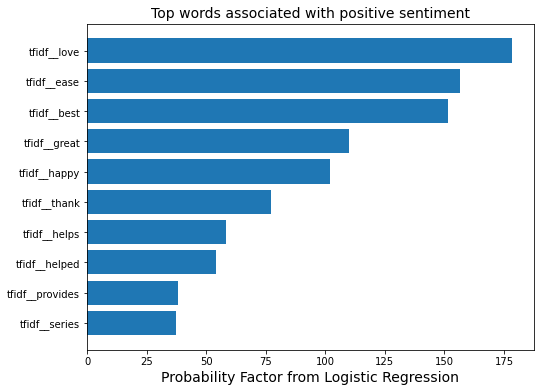

In [45]:
vis_logit_coef(lm.coef_, vectorizer, 'positive')

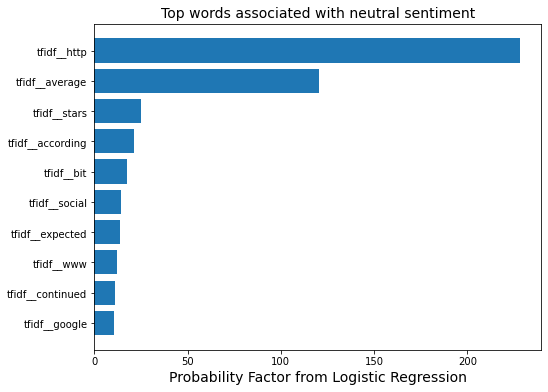

In [46]:
vis_logit_coef(lm.coef_, vectorizer, 'neutral')

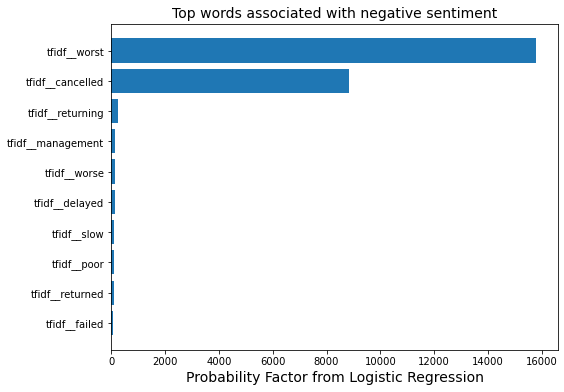

In [47]:
vis_logit_coef(lm.coef_, vectorizer, 'negative')

It is interesting to see that after adding information such as authors and news sources, the most predictive features are still certain words from the article text. None of the features generated by other columns appears in the top 10 coefficients in any of the categories. This also explains why our model accuracy is almost unchanged even with the added features. 

I will also look at the confusion matrix:

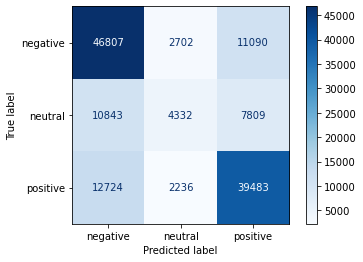

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lm, X_test_transformed, y_test, 
                                      cmap='Blues', display_labels = ['negative', 'neutral', 'positive'])

In [41]:
print(f'The precision for a positive review is: {round(39483/(39483+7809+11090),2)}')
print(f'The recall for a positive review is: {round(39483/(39483+2236+12724),2)} \n')

print(f'The precision for a neutral review is: {round(4332/(4332+2702+2236),2)}')
print(f'The recall for a neutral review is: {round(4332/(7809+10843+4332),2)} \n')

print(f'The precision for a negative review is: {round(46807/(46807+10843+12724),2)}')
print(f'The recall for a negative review is: {round(46807/(46807+2702+11090),2)} \n')

The precision for a positive review is: 0.68
The recall for a positive review is: 0.73 

The precision for a neutral review is: 0.47
The recall for a neutral review is: 0.19 

The precision for a negative review is: 0.67
The recall for a negative review is: 0.77 



Looking at the precision and recall numbers, it seems that the model is doing a decent job catching positive or negative sentiment in the article. Articles with positive sentiment is correctly identified by the model 73% of the times, and when the model predict a positive sentiment, it is the correct prediction in 68% of the times. The numbers for the negative sentiment are very similar.

However, the model is not doing a great job at identifying neutral sentiment, which is probably because the definition of "neutral" is somewhat vague to begin with. Only 19% of the articles with neutral sentiment are correctly identified, and for those articles predicted to have a neutral sentiment, only 47% of them are correct. 

## Conclusion and Next Step

I have now completed my modeling to predict the sentiment of Covid news articles. I started by exploring the text itself and applying different processing transformations, including a Word2Vec embedding trained by my own neural network. My best model with features from the text alone was able to achieve 65.96% testing accuracy. Adding other potentially important features (as found in my EDA) does not further improve the model performance. On top of the body text, my final model incorporated the author, country, news source information and has a 65.66% accuracy rate. The model is doing a better job at identifying positive or negative sentiment than identifying a neutral sentiment.

It is encouraging to see that my word processing is carrying the load for my model prediction. For NLP to be useful in the business world, one would like to see the processing on the text itself to produce useful information and help prediction. It would be helpful to know that we are able to predict the sentiment of a written text by the content of the text itself rather than relying on other information such as the authors or sources of the text. 

For next step of this project, I would like to explore more advanced NLP models and see how they help my model perform. The Word2Vec and LexVec embedding I used here is more like a first step into the world of NLP. More advanced models are already developed, and I would like to learn more about their application and apply them to this project. Another thing I would like to do is the unsupervised topic modeling for the articles. I would like to explore more about how the machine classifies the unlabeled articles and whether I, as a human, can make sense of resulted clusters. 

This project will be concluded here, but I am really interested in the world of NLP and will not stop learning about it!